# About

This notebook will be the main evaluations of the models.

Credits to Garg et. al for the code, which we modified. The original source can be found [here](https://github.com/dtsip/in-context-learning)

In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
# Displaying the directories
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,mamba,kernel_regression,mamba_kernel_regression,,-1,-1,20,12,NaN,mamba_kernel_regression
1,nanogpt,kernel_regression,nanogpt_kernel_regression,,-1,-1,5,12,8.0,nanogpt_kernel_regression


In [3]:
# Defining some hyperparameters for generating figures
task = "kernel_regression"
run_id_nanogpt = "nanogpt"
run_path_nanogpt = os.path.join(run_dir, task, run_id_nanogpt)

run_id_mamba = "mamba"
run_path_mamba = os.path.join(run_dir, task, run_id_mamba)

# Running Metrics

Recomputing metrics: getting nanoGPT and Mamba to run on the same dataset to get an equal comparison and also adding the distribution shifts

In [4]:
print(run_path_nanogpt)
print(run_path_mamba)

../models\kernel_regression\nanogpt
../models\kernel_regression\mamba


In [5]:
get_run_metrics([run_path_nanogpt, run_path_mamba])

c:\Users\jenni\OneDrive\Documents\Cal2024-2025\CS182\Project\cs182_final_proj\src\eval.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path, ma

{'standard': {'nanogpt_embd=256_layer=12_head=8': {'mean': [0.9503212571144104,
    0.8352333307266235,
    1.0619752407073975,
    0.976457953453064,
    1.0280380249023438,
    1.1908278465270996,
    0.9996374845504761,
    1.0044487714767456,
    0.9761763215065002,
    0.9470874071121216,
    1.1674669981002808,
    1.130314588546753,
    1.1333760023117065,
    1.0708378553390503,
    1.1461899280548096,
    1.216449499130249,
    0.9704461693763733,
    1.041713833808899,
    0.8598734140396118,
    0.9405086636543274,
    0.8570860028266907,
    0.8894726037979126,
    0.9507490396499634,
    0.9706036448478699,
    1.1739492416381836,
    1.0069588422775269,
    0.8318958282470703,
    1.0563502311706543,
    0.9662994146347046,
    0.9663917422294617,
    1.1120413541793823,
    1.183579921722412,
    1.0327996015548706,
    1.263777494430542,
    1.0862913131713867,
    1.143581748008728,
    1.175100326538086,
    1.1295888423919678,
    1.2583417892456055,
    1.0101300477

# Figure 1: Context Window Size vs. Squared Error

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


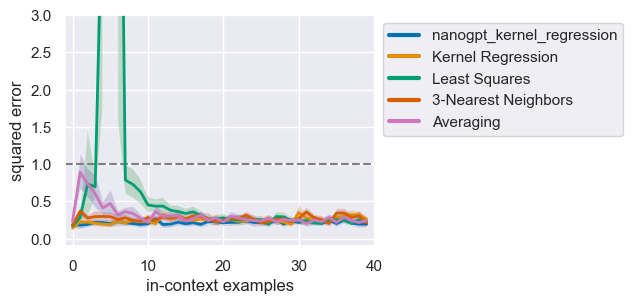

In [ ]:
def valid_row(r):
    return r.task == task and r.run_id == run_id_nanogpt

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path_nanogpt, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task + "_" + run_id_nanogpt]
basic_plot(metrics["standard"], models=models)
plt.show()

# Figure 2: Context Window Size vs. Distribution Shifts

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 2941.99it/s]


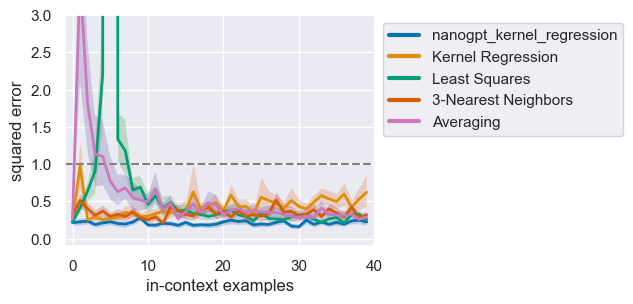

In [7]:
metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path_nanogpt, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task + "_" + run_id_nanogpt]
basic_plot(metrics["skewed"], models=models)
plt.show()

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


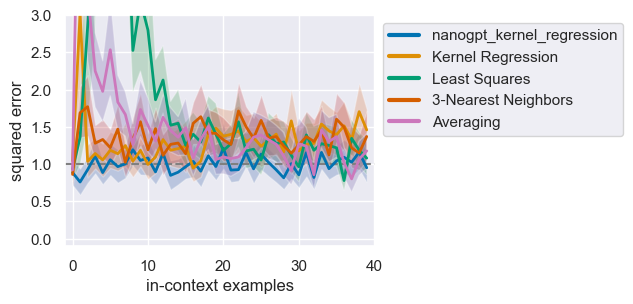

In [15]:
metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path_nanogpt, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task + "_" + run_id_nanogpt]
basic_plot(metrics["noisyKR"], models=models)
plt.show()

# Figure 3: ICL Regression Score

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [22]:
def valid_row_nanogpt(r):
    return r.task == task and r.run_id == run_id_nanogpt

def valid_row_mamba(r):
    return r.task == task and r.run_id == run_id_mamba

In [43]:
def compute_icl_regression_score(model_name):
    if model_name == "nanogpt_kernel_regression":
        metrics = collect_results(run_dir, df, valid_row=valid_row_nanogpt)
    elif model_name == "mamba_kernel_regression":
        metrics = collect_results(run_dir, df, valid_row=valid_row_mamba)
    else:
        raise Exception("invalid model name")

    print(metrics["standard"].keys())

    baseline_names = ['3-Nearest Neighbors', 'Averaging', 'Least Squares', 'Kernel Regression']
    zero_losses = np.array(metrics["standard"]["Zero Estimator"]["mean"])
    model_losses = np.array(metrics["standard"][model_name]["mean"])

    icl_scores = {}

    for baseline_name in baseline_names:
        baseline_losses = metrics["standard"][baseline_name]["mean"]

        numerator = np.sum(model_losses - zero_losses)
        denominator = np.sum(baseline_losses - zero_losses)

        score = numerator / denominator if denominator != 0 else float("nan")
        icl_scores[baseline_name] = score

    return icl_scores

In [44]:
nanogpt_icl_scores = compute_icl_regression_score("nanogpt_kernel_regression")

for baseline_name, icl_score in nanogpt_icl_scores.items():
    print(baseline_name, icl_score)

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 3000.93it/s]

dict_keys(['nanogpt_kernel_regression', 'Least Squares', 'Zero Estimator', '3-Nearest Neighbors', 'Averaging', 'Kernel Regression'])
3-Nearest Neighbors 0.09128457099399041
Averaging 0.05702224975298698
Least Squares 0.0008081874002358159
Kernel Regression 0.14003082806648762


In [45]:
mamba_icl_scores = compute_icl_regression_score("mamba_kernel_regression")

for baseline_name, icl_score in mamba_icl_scores.items():
    print(baseline_name, icl_score)

mamba_kernel_regression mamba


100%|██████████| 3/3 [00:00<?, ?it/s]

dict_keys(['mamba_kernel_regression', 'Least Squares', 'Zero Estimator', '3-Nearest Neighbors', 'Averaging', 'Kernel Regression'])
3-Nearest Neighbors 0.9456880999111257
Averaging 0.15418122384403185
Least Squares 0.0028490142874787188
Kernel Regression -7.4044843791996495


In [46]:
# print(metrics['standard'].keys())

In [47]:
# Sort models by score
def plot_icl_regression_score(icl_scores, model_name):
    sorted_scores = dict(sorted(icl_scores.items(), key=lambda x: -x[1]))

    plt.figure(figsize=(8, 4))
    plt.bar(sorted_scores.keys(), sorted_scores.values(), color="skyblue")
    plt.axhline(1.0, color="gray", linestyle="--", label="Baseline (score = 1)")
    plt.axhline(0.0, color="red", linestyle="--", label="Zero predictor")

    plt.ylabel("ICL Regression Score")
    plt.title(f"In-Context Learning Regression Scores for {model_name}")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

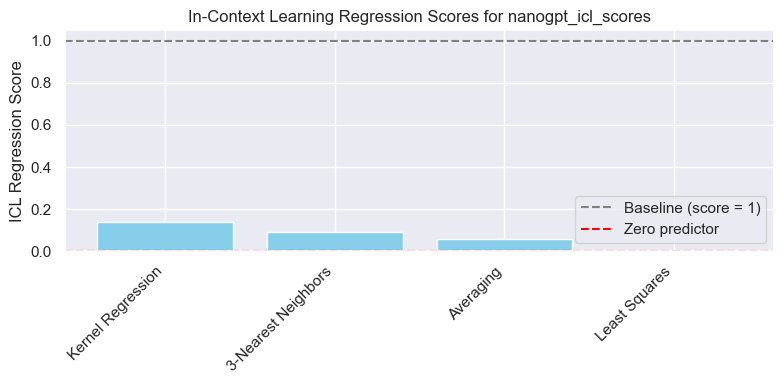

In [48]:
plot_icl_regression_score(nanogpt_icl_scores, "nanogpt_icl_scores")

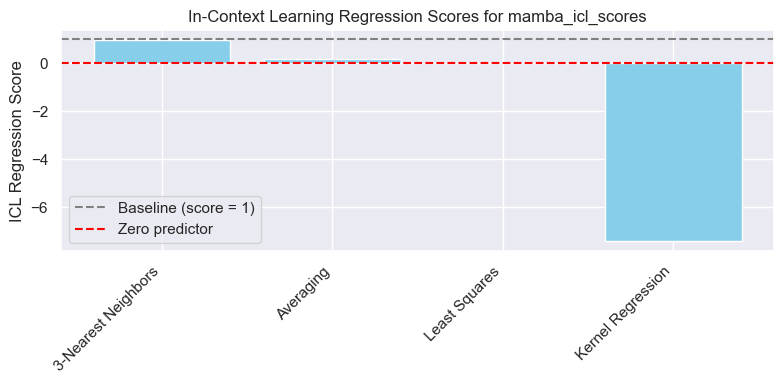

In [49]:
plot_icl_regression_score(mamba_icl_scores, "mamba_icl_scores")